# Try implementation two models based on asymmetry  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

Start by loading the training data generated with generate_FC_data.ipynb

In [2]:
#load datapath for clean training data that is generated
datapath = '../../cleanData/csvs/resonant/'

dataset = pd.read_csv(datapath+'25-3-25-fillFac.csv')
#remove junk columns
dataset = dataset.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

We can then split the data into training and testing sets, note, we will remove systems that go unstable in 1e4 orbits from the testing set

In [3]:
def train_test(dataset,features):
    '''divides the dataset into 80% training and 20% testing and returns training/testing sets'''
    Nrows = int(0.8*dataset.shape[0])
    train = dataset.iloc[:Nrows, :]
    test = dataset.iloc[Nrows:, :]
    #remove testing systems that go unstable in short integration phase

    test = test.drop(test[test['InitialStable']==False].index)
    return train[features], train['Stable'], test[features], test['Stable'], test['instability_time']

We can then define the features of interest and dividing training and testing sets

In [4]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno + ['Tsec', '3BRfill', '2BRfillnear', '2BRfillfar']

trainX, trainY, testX, testY, testInstability = train_test(dataset, features)

** Split the training data based on spacing specification **

In [5]:
data = pd.concat([trainX, trainY], axis=1)

In [44]:
# define where we draw the line when using crossing eccentricity
spaceL = 1 - (0.5)**(2/3)
dataeq = data[(data['EMcrossnear'] < spaceL) | (data['EMcrossfar'] < spaceL)]
datati = data[(data['EMcrossnear'] >= spaceL) & (data['EMcrossfar'] >= spaceL)]


In [45]:
modeleq = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 150,
                         )
modeleq.fit(dataeq[features],dataeq['Stable'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [46]:
modelti = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 150,
                         )
modelti.fit(datati[features],datati['Stable'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [47]:
datati

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,MEGNO,MEGNOstd,Tsec,3BRfill,2BRfillnear,2BRfillfar,Stable
3,0.406112,0.036478,0.002390,0.321071,0.427768,0.036219,0.008587,0.012958,2.002493,0.000335,18313.684674,0.122730,0.040700,0.099440,False
59,0.589032,0.113033,0.026377,1.384073,0.683494,0.062319,0.036501,NaN,10.941085,3.024556,19043.696827,0.045010,NaN,NaN,False
68,0.418176,0.069363,0.014684,0.041226,0.466753,0.107278,0.020084,NaN,6.454707,1.861060,25517.414074,0.117980,0.142469,0.269847,False
129,0.587274,0.080936,0.012949,16.014377,0.774623,0.074622,0.025130,NaN,2.005737,0.008592,24030.685738,0.020247,4.120672,NaN,True
165,0.553869,NaN,NaN,NaN,0.570252,NaN,NaN,NaN,NaN,NaN,17373.497418,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81883,0.406076,0.029834,0.005125,0.482713,0.778908,0.000676,0.002123,NaN,1.999791,0.000114,27732.785082,0.095631,0.034670,NaN,False
81942,0.403130,0.064701,0.000752,0.060023,0.577747,0.023222,0.004326,0.186355,1.999964,0.000026,47631.291615,0.065120,0.039704,0.048014,True
81970,0.469471,0.014134,0.004379,NaN,0.586679,0.090598,0.023671,0.838538,34.367543,8.310182,30964.344562,0.063373,0.692684,NaN,True
81981,0.405953,0.051913,0.001300,3.764945,0.632315,0.009069,0.005442,0.025920,1.985558,0.010136,47587.530262,0.016864,0.333092,NaN,True


In [48]:
dataeq

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,MEGNO,MEGNOstd,Tsec,3BRfill,2BRfillnear,2BRfillfar,Stable
0,0.060234,0.029447,0.001995,0.498040,0.504063,0.002900,0.000816,NaN,1.998619,0.003190,28431.355594,1.917395,8.652930,0.026594,False
1,0.080547,0.016559,0.000112,0.452015,0.240504,0.006736,0.001621,0.008674,2.001688,0.004966,3904.311701,0.407998,25.825316,0.019346,True
2,0.129660,0.028844,0.003181,1.001973,1.001981,0.001402,0.003742,0.010415,1.995051,0.003312,70073.695993,0.418203,1.051448,NaN,True
4,0.059897,0.028009,0.001623,0.341814,0.257596,0.053197,0.001287,0.034789,2.029737,0.013224,4110.203941,2.369149,3.462553,0.239528,False
5,0.062617,0.084135,0.002806,0.041345,0.185250,0.003223,0.000924,0.016763,7.309172,1.472227,12258.799896,0.979840,1.962447,0.181976,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81991,0.118143,0.083684,0.002563,0.104696,0.157872,0.077786,0.010786,0.126476,18.919227,4.938757,1703.191114,3.526605,1.667883,0.185554,False
81993,0.047094,0.017436,0.000500,0.872209,0.082328,0.158427,0.008790,0.196432,1.928366,0.039475,3420.172274,1.943687,8.647452,0.632690,False
81994,0.130226,0.036270,0.001641,1.840510,0.693580,0.043583,0.025085,NaN,1.995337,0.001962,2990.010409,0.536070,15.288754,NaN,True
81995,0.266853,NaN,NaN,NaN,0.311340,NaN,NaN,NaN,NaN,NaN,7514.090356,NaN,NaN,NaN,False


# tight systems

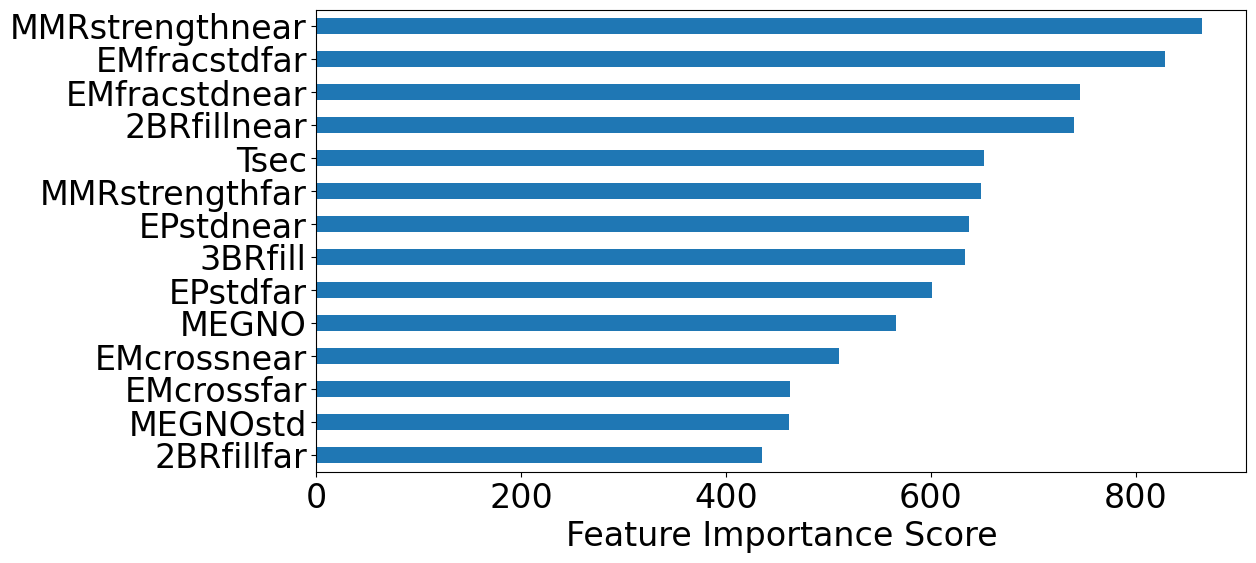

In [49]:
feat_imp = pd.Series(modelti.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,6), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()

# equal systems

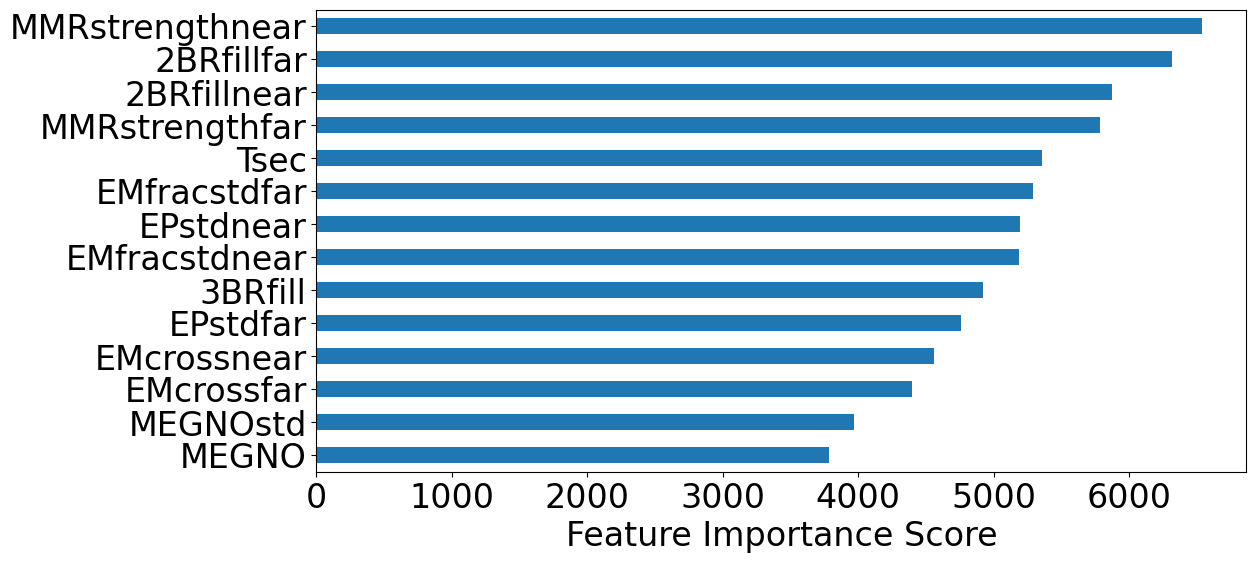

In [50]:
feat_imp = pd.Series(modeleq.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,6), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()

# now try on testing

In [51]:
from sklearn import metrics
from sklearn.metrics import roc_curve, confusion_matrix, auc
def ROC_curve( x,y):
    spaceL = 1 - (0.5)**(2/3)
    data = pd.concat([x, y], axis=1)
    dataeq = data[(data['EMcrossnear'] < spaceL) | (data['EMcrossfar'] < spaceL)]
    datati = data[(data['EMcrossnear'] >= spaceL) & (data['EMcrossfar'] >= spaceL)]
    predseq = modeleq.predict_proba(dataeq[features])[:,1]
    predsti = modelti.predict_proba(datati[features])[:,1]
    preds = np.concatenate((predseq,predsti))
    dy = np.concatenate((np.array(dataeq['Stable']), np.array(datati['Stable'])))
    fpr, tpr, ROCthresholds = roc_curve(dy, preds)
    roc_auc = metrics.roc_auc_score(dy, preds)
    return roc_auc, fpr, tpr, ROCthresholds

In [52]:
np.array(dataeq['Stable'])

array([False,  True,  True, ...,  True, False, False])

In [53]:
modelti.predict_proba(datati[features])[:,1]

array([0.15823594, 0.02237508, 0.02082437, ..., 0.54726326, 0.9794343 ,
       0.00873331], dtype=float32)

Text(0.5, 1.0, '(AUC = 0.9580)')

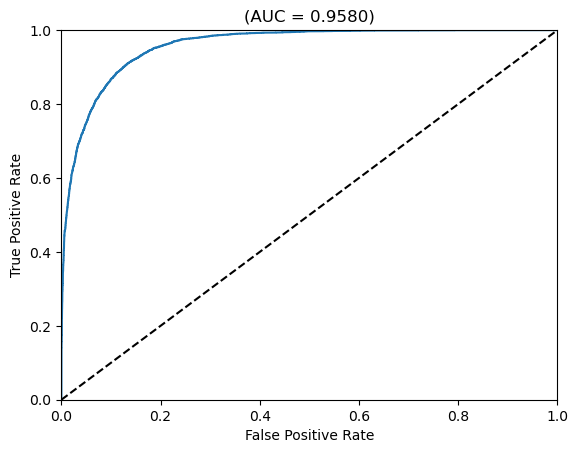

In [55]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(testX, testY)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('(AUC = {0:.4f})'.format(roc_auc))
